# Setting Config

In [1]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
model_name = 'DeepvoiceDetector_epoch99'
cuda = 'cuda:0'
max_length = 512

# Load Data

In [2]:
dataset = {'real' : {
            'label' : 'real',
            'wav' : '/root/NetChallenge10/dataset/real.wav',
            'text' : '이미 구속영장까지 발부되어 있어서 대출이 안될겁니다. 본인 명의가 범죄에 연루되었는지 확인해보는 차원에서 한번 대출을 받아서 송금을 해봐야 할 것 같습니다.'
        },
        'fake' : {
            'label' : 'fake',
            'wav' : '/root/NetChallenge10/dataset/fake.wav',
            'text' : '이미 구속영장까지 발부되어 있어서 대출이 안될겁니다. 본인 명의가 범죄에 연루되었는지 확인해보는 차원에서 한번 대출을 받아서 송금을 해봐야 할 것 같습니다.'
        }}

labels = ['real', 'fake']

In [3]:
# 실제 음성 데이터
#data = dataset['real']

# 딥보이스 데이터
data = dataset['fake']

In [4]:
import soundfile as sf
# 푸리에 변환
wav, _ = sf.read(data['wav'])

# Load Model

In [5]:
import torch
from merdataset import *
from config import *
from utils import *

model = torch.load('./ckpt/{}.pt'.format(model_name))
softmax = torch.nn.Softmax(dim=0)

model.eval()


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Kwav2vec_classfier(
  (classifier): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=768, out_features=512, bias=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
  (projection): Conv1d(1024, 768, kernel_size=(1,), stride=(1,), bias=False)
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

# model 조작하는 부분

In [6]:
model = torch.load('./ckpt/{}.pt'.format(model_name))

In [7]:
'''
from transformers.models.wav2vec2 import Wav2Vec2FeatureExtractor

processor = Wav2Vec2FeatureExtractor(sampling_rate=8000)

sampling_rate80 = processor(wav, sampling_rate=8000, return_attention_mask=True, return_tensors='pt')
sampling_rate160 = model.audio_encoder.processor(wav, sampling_rate=16000, return_attention_mask=True, return_tensors='pt')
print(sampling_rate80.input_values.shape)
print(sampling_rate160.input_values.shape)
'''

"\nfrom transformers.models.wav2vec2 import Wav2Vec2FeatureExtractor\n\nprocessor = Wav2Vec2FeatureExtractor(sampling_rate=8000)\n\nsampling_rate80 = processor(wav, sampling_rate=8000, return_attention_mask=True, return_tensors='pt')\nsampling_rate160 = model.audio_encoder.processor(wav, sampling_rate=16000, return_attention_mask=True, return_tensors='pt')\nprint(sampling_rate80.input_values.shape)\nprint(sampling_rate160.input_values.shape)\n"

In [8]:
import time

start = time.time()
#processor_output = model.audio_encoder.processor(wav, sampling_rate=16000, return_attention_mask=True, return_tensors='pt')
#processor_output = processor_output.to(cuda)
#processor_output.input_values.shape
from transformers.models.wav2vec2 import Wav2Vec2FeatureExtractor
processor = Wav2Vec2FeatureExtractor(sampling_rate=8000)
processor_output = processor(wav, sampling_rate=8000, return_attention_mask=True, return_tensors='pt')
processor_output = processor_output.to(cuda)
print("processor done :", time.time() - start, '초')

feature_extractor_output = model.audio_encoder.encoder.feature_extractor(processor_output.input_values)
feature_extractor_output = feature_extractor_output.transpose(1, 2)
print(feature_extractor_output.shape)
print("feature_extractor done :", time.time() - start, '초')

hidden_states, extract_features = model.audio_encoder.encoder.feature_projection(feature_extractor_output)
print(hidden_states.shape)
#hidden_states = model.audio_encoder.encoder._mask_hidden_states(hidden_states)
#print('hidden_states:', hidden_states.shape)
#print('extract_features:', extract_features.shape)
print("feature_projection done :", time.time() - start, '초')

encoder_outputs = model.audio_encoder.encoder.encoder(
            hidden_states,
            output_hidden_states=False
        )
hidden_states = encoder_outputs[0]
#print(hidden_states.shape)
#Total_output = (hidden_states, extract_features) + encoder_outputs[1:]
#Total_output
print("encoder done :", time.time() - start, '초')


hidden_batch = torch.Tensor().to(cuda)
hidden = hidden_states
seq = hidden.size()[1]
if seq > max_length:
    # truncation
    hidden = hidden[:,:max_length,:].to(cuda)
elif seq < max_length:
    # padding
    pad = torch.Tensor([[[0]*1024]*(max_length-seq)]).to(cuda)
    hidden = torch.cat([hidden,pad], dim=1)
hidden_batch = torch.cat([hidden_batch,hidden],dim=0)
#print(hidden_batch.shape)
#hidden_batch
print("max_length done :", time.time() - start, '초')


processor done : 0.009564399719238281 초
torch.Size([1, 1043, 512])
feature_extractor done : 1.3147602081298828 초
torch.Size([1, 1043, 1024])
feature_projection done : 1.3162972927093506 초
encoder done : 1.3871912956237793 초
max_length done : 1.3875298500061035 초


Text(0.5, 1.0, 'last_hidden_state')

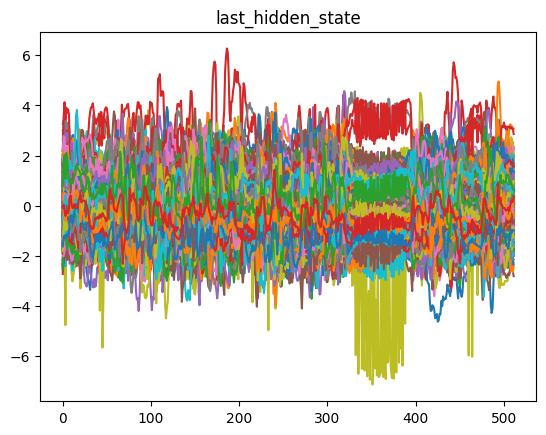

In [9]:
import matplotlib.pyplot as plt

plt.plot(hidden_batch.tolist()[0])
plt.title('last_hidden_state')